In [4]:
from datetime import datetime
import random
import numpy as np 
import networkx as nx 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.sparse import csr_matrix
from numpy.linalg import norm
from collections import Counter
import matplotlib.pyplot as plt
from numpy.linalg import norm
import math

In [5]:
def sbm_gender_homophily_adj_and_metadata(n_g1, n_g2, p_in, p_out, seed):
    np.random.seed(seed)
    sizes = [n_g1, n_g2]
    probs = [[p_in, p_out], [p_out, p_in]]
    G = nx.stochastic_block_model(sizes, probs, seed=seed)
    adj_matrix = nx.to_numpy_array(G)
    metadata = np.zeros((n_g1 + n_g2, 7))
    metadata[:n_g1, 1] = 1  # First block: gender 1
    metadata[n_g1:, 1] = 2  # Second block: gender 2
    return adj_matrix, metadata

In [6]:
def create_iid_core_fringe_graph(adj_matrix, k, seed=None, ff=False):
    """
    Creates a core-fringe graph using an IID sample of size k as the core.
    The fringe consists of all nodes connected to the core.
    
    Parameters:
      - adj_matrix (scipy.sparse matrix): full graph adjacency matrix.
      - k (int): number of core nodes to sample.
      - seed (int, optional): random seed.
      
    Returns:
      (core_fringe_adj, core_indices, fringe_indices)
    """
    if seed is not None:
        np.random.seed(seed)
    
    core_indices = np.random.choice(adj_matrix.shape[0], size=k, replace=False)
    is_core = np.zeros(adj_matrix.shape[0], dtype=bool)
    is_core[core_indices] = True

    A = csr_matrix(adj_matrix)
    total_edges_original = int(A.nnz / 2)
    print(f"Total edges in original adjacency: {total_edges_original}")
    neighbors = A[core_indices].nonzero()[1]
    fringe_indices = np.setdiff1d(np.unique(neighbors), core_indices)
    
    fringe_frignge_adj = A[fringe_indices, :][:, fringe_indices]
    # Build a mask that keeps only core-core and core-fringe edges.
    # Create sparse mask matrix
    mask_data = []
    mask_rows = []
    mask_cols = []
    
    # Add core-core edges
    core_core_edges = A[core_indices][:, core_indices]
    for i, j in zip(*np.triu_indices_from(core_core_edges, k=1)):
        mask_rows.extend([core_indices[i], core_indices[j]])
        mask_cols.extend([core_indices[j], core_indices[i]])
        mask_data.extend([1, 1])
    
    # Add core-fringe edges
    core_fringe_edges = A[core_indices][:, fringe_indices]
    for i, j in zip(core_fringe_edges.nonzero()[0], core_fringe_edges.nonzero()[1]):
        mask_rows.extend([core_indices[i], fringe_indices[j]])
        mask_cols.extend([fringe_indices[j], core_indices[i]])
        mask_data.extend([1, 1])

    # Create sparse mask matrix
    mask = csr_matrix((mask_data, (mask_rows, mask_cols)), shape=A.shape)

    core_fringe_adj = A.multiply(mask)

    print(f"IID core")
    print(f"Core size: {len(core_indices)}")
    core_core_edges = int(np.sum(core_fringe_adj[core_indices][:, core_indices]) / 2)
    core_fringe_edges = int(np.sum(core_fringe_adj[core_indices][:, fringe_indices]) / 2)
    print(f"Number of core-core edges: {core_core_edges}")
    print(f"Number of core-fringe edges: {core_fringe_edges}")
    
    # Calculate number of fringe-fringe edges lost
    fringe_fringe_edges = total_edges_original - (core_core_edges + core_fringe_edges)
    print(f"Number of fringe-fringe edges (lost): {fringe_fringe_edges}")

    # After constructing core_fringe_adj
    fringe_adj = core_fringe_adj[fringe_indices, :][:, fringe_indices]
    assert fringe_adj.nnz == 0, "Fringe-fringe edges exist in the core-fringe adjacency matrix!"

    if ff:
        return core_fringe_adj, core_indices, fringe_indices, fringe_frignge_adj
    else:
        return core_fringe_adj, core_indices, fringe_indices

In [17]:
def fill_fringe_fringe_jaccard(adj_matrix, fringe_indices, threshold=0.5):
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    A_pred = A.astype(float).copy()
    # go over all pairs of fringe-fringe and compute the jaccard sim of their adj_list
    # and if above threshold add an edge between the nodes and return this A_pred
    neighbor_set = {}
    for node in fringe_indices:
        neighbor_set[node] = set(np.nonzero(A[node])[0])

    L = len(fringe_indices)
    added_edges = 0
    for i in range(L):
        u = fringe_indices[i]
        for j in range(i+1, L):
            v = fringe_indices[j]
            
            # skip if already added edge
            if A_pred[u, v] > 0:
                continue
                
            neighbors_u = neighbor_set[u]
            neighbors_v = neighbor_set[v]

            union_size = len(neighbors_u | neighbors_v)
            if union_size == 0:
                sim = 0.0
            else:
                sim = len(neighbors_u & neighbors_v) / union_size 
            # print(f"Jaccard Sim: {sim}")
            if sim >= threshold:
                A_pred[u,v] = 1.0
                A_pred[v,u] = 1.0
                added_edges += 1
    print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

def fill_fringe_fringe_cosine(adj_matrix, core_indices, fringe_indices, labels, threshold=0.5):
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    A_pred = A.astype(float).copy()
    # go over all fringe nodes, and make a 2D vector : [# of class 1 nghs, # of class 2 nghs]
    # compute the cosine between this to add an edge between fringe nodes 
    core_classes = labels[core_indices].astype(int)
    class_labels = np.unique(core_classes)
    fringe_vecs = {}
    for u in fringe_indices:
        vec = np.zeros(2, dtype=int)
        neighbors = np.where(A[u, core_indices] > 0)[0]
        for idx in neighbors:
            cls = core_classes[idx]
            if cls == class_labels[0]:
                vec[0] += 1
            elif cls == class_labels[1]:
                vec[1] += 1
        fringe_vecs[u] = vec

    L = len(fringe_indices)
    added_edges = 0
    for i in range(L):
        u = fringe_indices[i]
        for j in range(i+1,L):
            v = fringe_indices[j]

            # skip if already added edge
            if A_pred[u, v] > 0:
                continue

            vec_u = fringe_vecs[u]
            vec_v = fringe_vecs[v]
            if norm(vec_u) == 0 or norm(vec_v) == 0:
                sim = 0.0
            else:
                sim = np.dot(vec_u, vec_v) / (norm(vec_u) * norm(vec_v))

            if sim >= threshold:
                A_pred[u,v] = 1.0
                A_pred[v,u] = 1.0
                added_edges += 1

    print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

def fill_fringe_fringe_cosine_adj(adj_matrix, fringe_indices, labels, threshold=0.5):
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    A_pred = A.astype(float).copy()
    L = len(fringe_indices)
    added_edges = 0
    for i in range(L):
        u = fringe_indices[i]
        for j in range(i+1,L):
            v = fringe_indices[j]

            # skip if already added edge
            if A_pred[u, v] > 0:
                continue

            vec_u = A[u,:]
            vec_v = A[v,:]
            if norm(vec_u) == 0 or norm(vec_v) == 0:
                sim = 0.0
            else:
                sim = np.dot(vec_u, vec_v) / (norm(vec_u) * norm(vec_v))
                # print(f"Cosine Sim: {sim}")

            if sim >= threshold:
                A_pred[u,v] = 1.0
                A_pred[v,u] = 1.0
                added_edges += 1

    print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

def fill_fringe_fringe_adamic_adar(adj_matrix, fringe_indices, labels, threshold=0.5):
    # fill ff using Adamic/Adar score
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    A_pred = A.astype(float).copy()
    neighbor_set = {}
    for node in fringe_indices:
        neighbor_set[node] = set(np.nonzero(A[node])[0])

    L = len(fringe_indices)
    added_edges = 0
    for i in range(L):
        u = fringe_indices[i]
        for j in range(i+1, L):
            v = fringe_indices[j]
            
            # skip if already added edge
            if A_pred[u, v] > 0:
                continue
                
            neighbors_u = neighbor_set[u]
            neighbors_v = neighbor_set[v]

            intersection = neighbors_u & neighbors_v
            
            if len(intersection) == 0:
                sim = 0.0
            else:
                sim = 0.0
                for w in intersection:
                    deg_w = len(set(np.nonzero(A[w])[0]))
                    if deg_w <= 1:
                        continue
                    sim += 1 / math.log(deg_w)
            # print(f"Adamic/Adar Sim: {sim}")
            if sim >= threshold:
                A_pred[u,v] = 1.0
                A_pred[v,u] = 1.0
                added_edges += 1
    print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

In [10]:
def auc_confidence_interval(y_true, y_scores, n_bootstraps=1000, random_seed=42):
    rng = np.random.RandomState(random_seed)
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            # skip if only one class in the sample
            continue
        score = roc_auc_score(y_true[indices], y_scores[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.sort(bootstrapped_scores)
    lower = sorted_scores[int(0.025 * len(sorted_scores))]
    upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return lower, upper

In [11]:
def logistic_regression_model(
    adj_matrix, core_indices, 
    fringe_indices, metadata, 
    feature='link', lr_kwargs=None, 
    seed=None, threshold=0.5,
    ff_imputation='jaccard'
):
    gender = metadata[:, 1].astype(int)  # Convert to integer
    dorm = metadata[:, 4]
    added_edges = 0
    if ff_imputation == 'jaccard':
        # impute the fringe-fringe edges 
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_jaccard(adj_matrix, fringe_indices, threshold=threshold)
    elif ff_imputation == 'cosine':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_cosine(adj_matrix, core_indices, fringe_indices, gender, threshold=threshold)
    elif ff_imputation == 'cosine_adj':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_cosine_adj(adj_matrix, fringe_indices, gender, threshold=threshold)
    elif ff_imputation == 'adamic_adar':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_adamic_adar(adj_matrix, fringe_indices, gender, threshold=threshold)
    else:
        ff_imputed_adj_matrix = adj_matrix
    if feature == 'link':
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test = ff_imputed_adj_matrix[fringe_indices, :]
    elif feature == 'triangles':
        # @toDo: implement this
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test = ff_imputed_adj_matrix[fringe_indices, :]
    elif feature == 'node2vec':
        # @toDo: implement this
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test = ff_imputed_adj_matrix[fringe_indices, :]
        
    print("\n Feature Space (Core-Fringe)")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    y_test = gender[fringe_indices]
    unique_train_classes = np.unique(y_train)
    print(f"Unique training classes: {unique_train_classes}")
    model = LogisticRegression(**lr_kwargs, random_state=seed)
    model.fit(X_train, y_train)
    beta = model.coef_.flatten()
    # print(f"\nModel Analysis:")
    # print(f"Number of non-zero coefficients: {np.count_nonzero(beta)}")
    # print(f"Mean absolute coefficient: {np.mean(np.abs(beta)):.4f}")
    # print(f"Max coefficient: {np.max(np.abs(beta)):.4f}")
    # print(f"Min coefficient: {np.min(np.abs(beta)):.4f}")
    # print(f"Max coefficient (No-Abs): {np.max(beta):.4f}")
    # print(f"Min coefficient (No-Abs): {np.min(beta):.4f}")

    y_test_pred = model.predict(X_test)
    y_test_scores = model.predict_proba(X_test)
    
    # Verify class order and AUC calculation
    print("\nClass Order Verification:")
    print(f"Model classes_: {model.classes_}")  # Order of classes in the model
    print(f"Unique test classes: {np.unique(y_test)}")  # Classes in test set
    print(f"Class distribution in test: {dict(Counter(y_test))}")
    print(f"Prediction distribution: {dict(Counter(y_test_pred))}")

    # Calculate AUC for each class
    for i, class_label in enumerate(model.classes_):
        class_auc = roc_auc_score(y_test == class_label, y_test_scores[:, i])
        print(f"AUC for class {class_label}: {class_auc:.4f}")
    
    # Use the correct class index for AUC
    positive_class_idx = np.where(model.classes_ == 2)[0][0]  # Assuming 2 is our positive class
    auc = roc_auc_score(y_test, y_test_scores[:, positive_class_idx])
    accuracy = accuracy_score(y_test, y_test_pred)
    
    # Compute AUC confidence interval
    auc_lower, auc_upper = auc_confidence_interval(y_test, y_test_scores[:, positive_class_idx])
    print(f"AUC 95% CI: [{auc_lower:.3f}, {auc_upper:.3f}]")
    
    print(f"\nFinal Results:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test ROC AUC: {auc:.4f}")
    print(f"Training class distribution: {dict(Counter(y_train))}")
    print(f"Test class distribution: {dict(Counter(y_test))}")

    return beta, accuracy, auc, (auc_lower, auc_upper), added_edges
    

In [12]:
seed = random.seed(datetime.now().timestamp())
sbm_adj_matrix, metadata = sbm_gender_homophily_adj_and_metadata(500, 500, 0.15, 0.1, seed=seed)
print(sbm_adj_matrix.shape)
print(metadata.shape)
print(metadata[:, 1].shape)
adj_matrix, core_indices, fringe_indices, ff_true = create_iid_core_fringe_graph(sbm_adj_matrix, 300, seed=seed, ff=True)
print(adj_matrix.shape)
print(len(core_indices))
print(len(fringe_indices))
lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
_, acc, auc, auc_ci, added_edges = logistic_regression_model(adj_matrix, core_indices, fringe_indices, 
                                                metadata, feature='link', lr_kwargs=lr_kwargs, 
                                                seed=seed, threshold=0.10, ff_imputation='adamic_adar')
L = len(fringe_indices)
print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")

(1000, 1000)
(1000, 7)
(1000,)
Total edges in original adjacency: 62792
IID core
Core size: 300
Number of core-core edges: 5619
Number of core-fringe edges: 13138
Number of fringe-fringe edges (lost): 44035
(1000, 1000)
300
700
Possible FF Edges: 489300 	 Added Edges : 485352

 Feature Space (Core-Fringe)
X_train shape: (300, 1000)
y_train shape: (300,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 346, 2: 354}
Prediction distribution: {1: 687, 2: 13}
AUC for class 1: 0.9124
AUC for class 2: 0.9124
AUC 95% CI: [0.892, 0.933]

Final Results:
Test Accuracy: 0.5129
Test ROC AUC: 0.9124
Training class distribution: {2: 146, 1: 154}
Test class distribution: {1: 346, 2: 354}
Possible FF Edges: 489300 	 Added Edges : 485352


In [22]:
def jaccard_threshold_sweep():
    # Seed and generate SBM with gender homophily
    seed = random.seed(datetime.now().timestamp())
    sbm_adj_matrix, metadata = sbm_gender_homophily_adj_and_metadata(
        500, 500, 0.15, 0.1, seed=seed
    )

    # Build core-fringe split
    adj_matrix, core_indices, fringe_indices, ff_true = create_iid_core_fringe_graph(
        sbm_adj_matrix, 300, seed=seed, ff=True
    )

    # Core–fringe baseline
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
        adj_matrix, core_indices, fringe_indices,
        metadata, feature='link', lr_kwargs=lr_kwargs,
        seed=seed, threshold=0.10, ff_imputation=None
    )

    # Sweep thresholds
    thresholds = np.linspace(0.0, 0.9, 20)
    sweep_aucs = []
    sweep_cis = []
    sweep_added = []

    for thresh in thresholds:
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=thresh, ff_imputation='jaccard'
        )
        sweep_aucs.append(auc)
        sweep_cis.append(auc_ci)
        sweep_added.append(added_edges)

    # Prepare error bars for sweep
    lowers = [auc - ci[0] for auc, ci in zip(sweep_aucs, sweep_cis)]
    uppers = [ci[1] - auc for auc, ci in zip(sweep_aucs, sweep_cis)]

    # Prepare core–fringe arrays
    cf_aucs = np.full_like(thresholds, cf_auc, dtype=float)
    cf_lowers = np.full_like(thresholds, cf_auc - cf_ci[0], dtype=float)
    cf_uppers = np.full_like(thresholds, cf_ci[1] - cf_auc, dtype=float)

    # Plot
    plt.figure(figsize=(10, 5))

    # Jaccard sweep with error bars
    plt.errorbar(
        thresholds, sweep_aucs,
        yerr=[lowers, uppers],
        fmt='-o', capsize=4,
        label='Jaccard-imputed (95% CI)'
    )

    # Core–fringe baseline as horizontal band
    plt.plot(
        thresholds, cf_aucs,
        '--', linewidth=2,
        label='Core–Fringe baseline'
    )
    plt.fill_between(
        thresholds,
        cf_aucs - cf_lowers,
        cf_aucs + cf_uppers,
        alpha=0.2
    )

    plt.xlabel("Jaccard Threshold")
    plt.ylabel("ROC AUC")
    plt.title("Link Prediction AUC: Sweep vs. Core–Fringe Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'thresholds': thresholds,
        'sweep_aucs': sweep_aucs,
        'sweep_cis': sweep_cis,
        'sweep_added': sweep_added,
        'cf_auc': cf_auc,
        'cf_ci': cf_ci,
        'cf_added_edges': cf_added
    }


def cosine_threshold_sweep():
    # Seed and generate SBM with gender homophily
    seed = random.seed(datetime.now().timestamp())
    sbm_adj_matrix, metadata = sbm_gender_homophily_adj_and_metadata(
        500, 500, 0.15, 0.1, seed=seed
    )

    # Build core-fringe split
    adj_matrix, core_indices, fringe_indices, ff_true = create_iid_core_fringe_graph(
        sbm_adj_matrix, 300, seed=seed, ff=True
    )

    # Core–fringe baseline
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
        adj_matrix, core_indices, fringe_indices,
        metadata, feature='link', lr_kwargs=lr_kwargs,
        seed=seed, threshold=0.10, ff_imputation=None
    )

    # Sweep thresholds
    thresholds = np.linspace(0.0, 0.9, 20)
    sweep_aucs = []
    sweep_cis = []
    sweep_added = []

    for thresh in thresholds:
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=thresh, ff_imputation='cosine'
        )
        sweep_aucs.append(auc)
        sweep_cis.append(auc_ci)
        sweep_added.append(added_edges)

    # Prepare error bars for sweep
    lowers = [auc - ci[0] for auc, ci in zip(sweep_aucs, sweep_cis)]
    uppers = [ci[1] - auc for auc, ci in zip(sweep_aucs, sweep_cis)]

    # Prepare core–fringe arrays
    cf_aucs = np.full_like(thresholds, cf_auc, dtype=float)
    cf_lowers = np.full_like(thresholds, cf_auc - cf_ci[0], dtype=float)
    cf_uppers = np.full_like(thresholds, cf_ci[1] - cf_auc, dtype=float)

    # Plot
    plt.figure(figsize=(10, 5))

    # Cosine sweep with error bars
    plt.errorbar(
        thresholds, sweep_aucs,
        yerr=[lowers, uppers],
        fmt='-o', capsize=4,
        label='Cosine-imputed (95% CI)'
    )

    # Core–fringe baseline as horizontal band
    plt.plot(
        thresholds, cf_aucs,
        '--', linewidth=2,
        label='Core–Fringe baseline'
    )
    plt.fill_between(
        thresholds,
        cf_aucs - cf_lowers,
        cf_aucs + cf_uppers,
        alpha=0.2
    )

    plt.xlabel("Cosine Threshold")
    plt.ylabel("ROC AUC")
    plt.title("Link Prediction AUC: Sweep vs. Core–Fringe Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'thresholds': thresholds,
        'sweep_aucs': sweep_aucs,
        'sweep_cis': sweep_cis,
        'sweep_added': sweep_added,
        'cf_auc': cf_auc,
        'cf_ci': cf_ci,
        'cf_added_edges': cf_added
    }

def cosine_adj_threshold_sweep():
    # Seed and generate SBM with gender homophily
    seed = random.seed(datetime.now().timestamp())
    sbm_adj_matrix, metadata = sbm_gender_homophily_adj_and_metadata(
        500, 500, 0.15, 0.1, seed=seed
    )

    # Build core-fringe split
    adj_matrix, core_indices, fringe_indices, ff_true = create_iid_core_fringe_graph(
        sbm_adj_matrix, 300, seed=seed, ff=True
    )

    # Core–fringe baseline
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
        adj_matrix, core_indices, fringe_indices,
        metadata, feature='link', lr_kwargs=lr_kwargs,
        seed=seed, threshold=0.10, ff_imputation=None
    )

    # Sweep thresholds
    thresholds = np.linspace(0.0, 0.9, 20)
    sweep_aucs = []
    sweep_cis = []
    sweep_added = []

    for thresh in thresholds:
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=thresh, ff_imputation='cosine_adj'
        )
        sweep_aucs.append(auc)
        sweep_cis.append(auc_ci)
        sweep_added.append(added_edges)

    # Prepare error bars for sweep
    lowers = [auc - ci[0] for auc, ci in zip(sweep_aucs, sweep_cis)]
    uppers = [ci[1] - auc for auc, ci in zip(sweep_aucs, sweep_cis)]

    # Prepare core–fringe arrays
    cf_aucs = np.full_like(thresholds, cf_auc, dtype=float)
    cf_lowers = np.full_like(thresholds, cf_auc - cf_ci[0], dtype=float)
    cf_uppers = np.full_like(thresholds, cf_ci[1] - cf_auc, dtype=float)

    # Plot
    plt.figure(figsize=(10, 5))

    # Cosine sweep with error bars
    plt.errorbar(
        thresholds, sweep_aucs,
        yerr=[lowers, uppers],
        fmt='-o', capsize=4,
        label='Cosine-Adj-imputed (95% CI)'
    )

    # Core–fringe baseline as horizontal band
    plt.plot(
        thresholds, cf_aucs,
        '--', linewidth=2,
        label='Core–Fringe baseline'
    )
    plt.fill_between(
        thresholds,
        cf_aucs - cf_lowers,
        cf_aucs + cf_uppers,
        alpha=0.2
    )

    plt.xlabel("Cosine Threshold")
    plt.ylabel("ROC AUC")
    plt.title("Link Prediction AUC: Sweep vs. Core–Fringe Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'thresholds': thresholds,
        'sweep_aucs': sweep_aucs,
        'sweep_cis': sweep_cis,
        'sweep_added': sweep_added,
        'cf_auc': cf_auc,
        'cf_ci': cf_ci,
        'cf_added_edges': cf_added
    }
    
def adamic_adar_threshold_sweep():
    # Seed and generate SBM with gender homophily
    seed = random.seed(datetime.now().timestamp())
    sbm_adj_matrix, metadata = sbm_gender_homophily_adj_and_metadata(
        500, 500, 0.15, 0.1, seed=seed
    )

    # Build core-fringe split
    adj_matrix, core_indices, fringe_indices, ff_true = create_iid_core_fringe_graph(
        sbm_adj_matrix, 300, seed=seed, ff=True
    )

    # Core–fringe baseline
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
        adj_matrix, core_indices, fringe_indices,
        metadata, feature='link', lr_kwargs=lr_kwargs,
        seed=seed, threshold=0.10, ff_imputation=None
    )

    # Sweep thresholds
    thresholds = np.linspace(0.0, 1.9, 40)
    sweep_aucs = []
    sweep_cis = []
    sweep_added = []

    for thresh in thresholds:
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=thresh, ff_imputation='adamic_adar'
        )
        sweep_aucs.append(auc)
        sweep_cis.append(auc_ci)
        sweep_added.append(added_edges)

    # Prepare error bars for sweep
    lowers = [auc - ci[0] for auc, ci in zip(sweep_aucs, sweep_cis)]
    uppers = [ci[1] - auc for auc, ci in zip(sweep_aucs, sweep_cis)]

    # Prepare core–fringe arrays
    cf_aucs = np.full_like(thresholds, cf_auc, dtype=float)
    cf_lowers = np.full_like(thresholds, cf_auc - cf_ci[0], dtype=float)
    cf_uppers = np.full_like(thresholds, cf_ci[1] - cf_auc, dtype=float)

    # Plot
    plt.figure(figsize=(10, 5))

    # Cosine sweep with error bars
    plt.errorbar(
        thresholds, sweep_aucs,
        yerr=[lowers, uppers],
        fmt='-o', capsize=4,
        label='Adamic/Adar-Adj-imputed (95% CI)'
    )

    # Core–fringe baseline as horizontal band
    plt.plot(
        thresholds, cf_aucs,
        '--', linewidth=2,
        label='Core–Fringe baseline'
    )
    plt.fill_between(
        thresholds,
        cf_aucs - cf_lowers,
        cf_aucs + cf_uppers,
        alpha=0.2
    )

    plt.xlabel("Adamic/Adar Threshold")
    plt.ylabel("ROC AUC")
    plt.title("Link Prediction AUC: Sweep vs. Core–Fringe Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'thresholds': thresholds,
        'sweep_aucs': sweep_aucs,
        'sweep_cis': sweep_cis,
        'sweep_added': sweep_added,
        'cf_auc': cf_auc,
        'cf_ci': cf_ci,
        'cf_added_edges': cf_added
    }

Total edges in original adjacency: 62729
IID core
Core size: 300
Number of core-core edges: 5751
Number of core-fringe edges: 13211
Number of fringe-fringe edges (lost): 43767

 Feature Space (Core-Fringe)
X_train shape: (300, 1000)
y_train shape: (300,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 356, 2: 344}
Prediction distribution: {1: 327, 2: 373}
AUC for class 1: 0.9119
AUC for class 2: 0.9119
AUC 95% CI: [0.889, 0.933]

Final Results:
Test Accuracy: 0.8243
Test ROC AUC: 0.9119
Training class distribution: {2: 156, 1: 144}
Test class distribution: {1: 356, 2: 344}
Possible FF Edges: 489300 	 Added Edges : 489300

 Feature Space (Core-Fringe)
X_train shape: (300, 1000)
y_train shape: (300,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 356, 2: 344}
Prediction distribution: {2: 631, 1: 69}
AUC for 

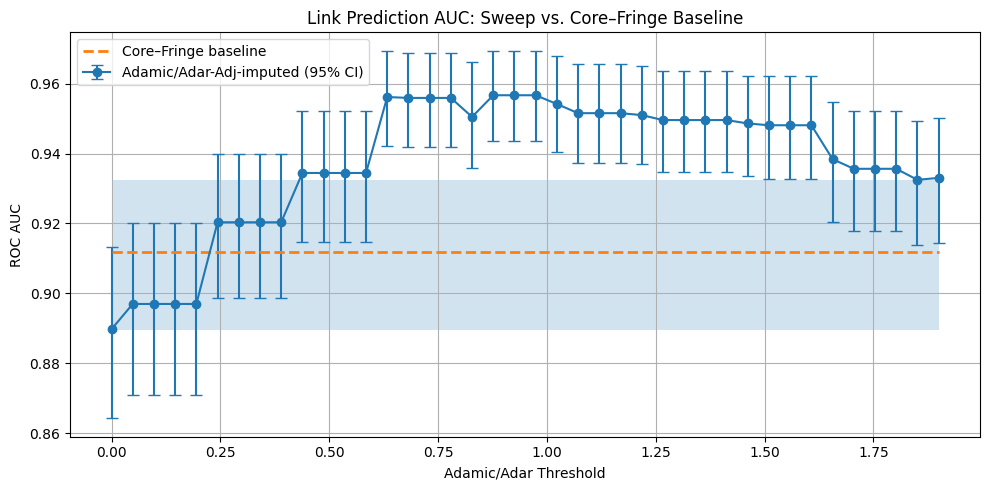

{'thresholds': array([0.        , 0.04871795, 0.0974359 , 0.14615385, 0.19487179,
        0.24358974, 0.29230769, 0.34102564, 0.38974359, 0.43846154,
        0.48717949, 0.53589744, 0.58461538, 0.63333333, 0.68205128,
        0.73076923, 0.77948718, 0.82820513, 0.87692308, 0.92564103,
        0.97435897, 1.02307692, 1.07179487, 1.12051282, 1.16923077,
        1.21794872, 1.26666667, 1.31538462, 1.36410256, 1.41282051,
        1.46153846, 1.51025641, 1.55897436, 1.60769231, 1.65641026,
        1.70512821, 1.75384615, 1.8025641 , 1.85128205, 1.9       ]),
 'sweep_aucs': [0.8897471910112359,
  0.8969738045466422,
  0.8969738045466422,
  0.8969738045466422,
  0.8969738045466422,
  0.9203357721452836,
  0.9203357721452836,
  0.9203357721452836,
  0.9203357721452836,
  0.9344460412856024,
  0.9344460412856024,
  0.9344460412856024,
  0.9344460412856024,
  0.9561748758818918,
  0.9559135746015155,
  0.9559135746015155,
  0.9559135746015155,
  0.9504915730337078,
  0.9566811471126208,
  0.9566

In [23]:
adamic_adar_threshold_sweep()

Total edges in original adjacency: 62275
IID core
Core size: 300
Number of core-core edges: 5574
Number of core-fringe edges: 13097
Number of fringe-fringe edges (lost): 43604

 Feature Space (Core-Fringe)
X_train shape: (300, 1000)
y_train shape: (300,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 344, 2: 356}
Prediction distribution: {1: 425, 2: 275}
AUC for class 1: 0.9030
AUC for class 2: 0.9030
AUC 95% CI: [0.881, 0.923]

Final Results:
Test Accuracy: 0.7929
Test ROC AUC: 0.9030
Training class distribution: {2: 144, 1: 156}
Test class distribution: {1: 344, 2: 356}
Possible FF Edges: 489300 	 Added Edges : 489300

 Feature Space (Core-Fringe)
X_train shape: (300, 1000)
y_train shape: (300,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 344, 2: 356}
Prediction distribution: {2: 599, 1: 101}
AUC for

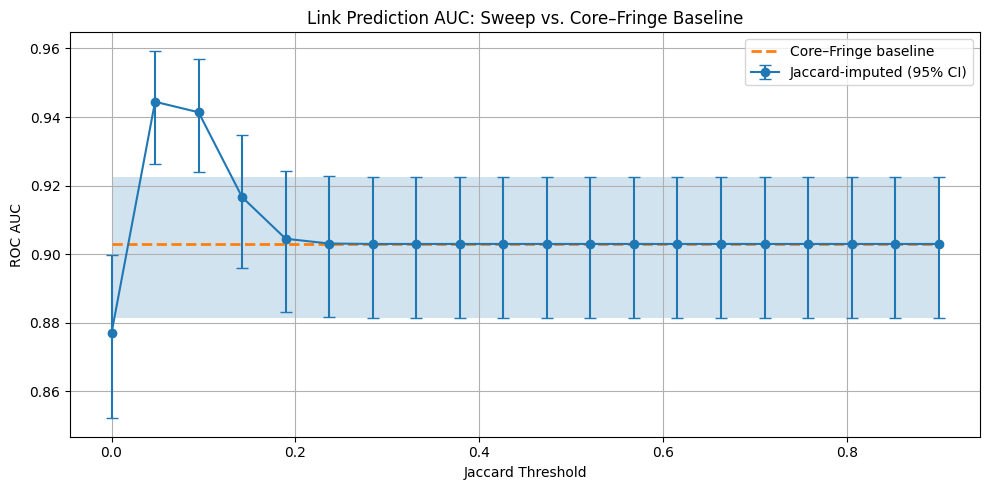

Total edges in original adjacency: 62216
IID core
Core size: 300
Number of core-core edges: 5496
Number of core-fringe edges: 13141
Number of fringe-fringe edges (lost): 43579

 Feature Space (Core-Fringe)
X_train shape: (300, 1000)
y_train shape: (300,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 360, 2: 340}
Prediction distribution: {1: 311, 2: 389}
AUC for class 1: 0.8932
AUC for class 2: 0.8932
AUC 95% CI: [0.868, 0.916]

Final Results:
Test Accuracy: 0.8100
Test ROC AUC: 0.8932
Training class distribution: {2: 160, 1: 140}
Test class distribution: {1: 360, 2: 340}
Possible FF Edges: 489300 	 Added Edges : 489300

 Feature Space (Core-Fringe)
X_train shape: (300, 1000)
y_train shape: (300,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 360, 2: 340}
Prediction distribution: {1: 201, 2: 499}
AUC for

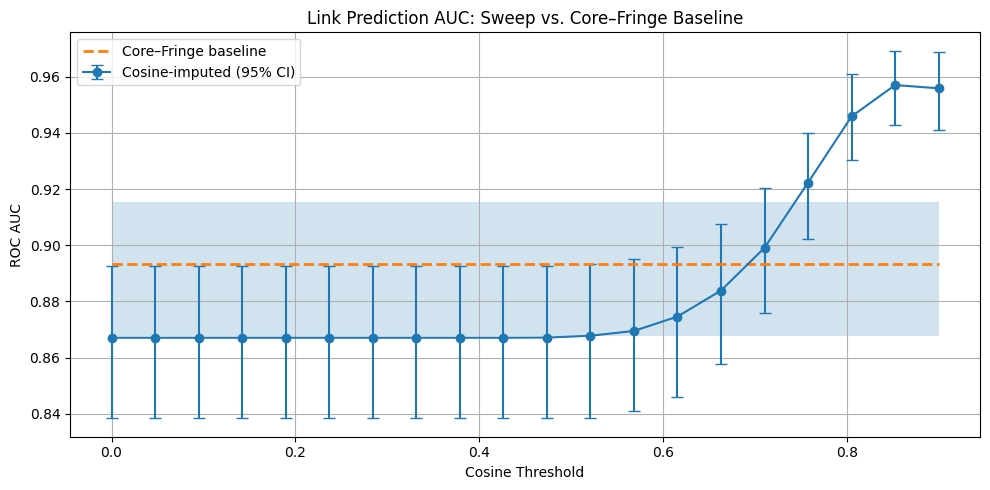

Total edges in original adjacency: 62243
IID core
Core size: 300
Number of core-core edges: 5641
Number of core-fringe edges: 13058
Number of fringe-fringe edges (lost): 43544

 Feature Space (Core-Fringe)
X_train shape: (300, 1000)
y_train shape: (300,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 355, 2: 345}
Prediction distribution: {1: 316, 2: 384}
AUC for class 1: 0.9182
AUC for class 2: 0.9182
AUC 95% CI: [0.896, 0.936]

Final Results:
Test Accuracy: 0.8414
Test ROC AUC: 0.9182
Training class distribution: {1: 145, 2: 155}
Test class distribution: {1: 355, 2: 345}
Possible FF Edges: 489300 	 Added Edges : 489300

 Feature Space (Core-Fringe)
X_train shape: (300, 1000)
y_train shape: (300,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 355, 2: 345}
Prediction distribution: {1: 518, 2: 182}
AUC for

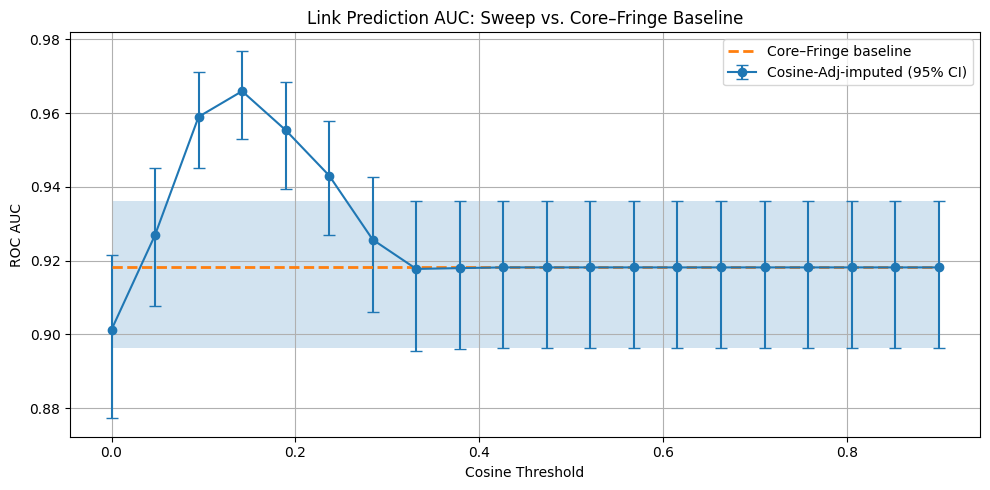

{'thresholds': array([0.        , 0.04736842, 0.09473684, 0.14210526, 0.18947368,
        0.23684211, 0.28421053, 0.33157895, 0.37894737, 0.42631579,
        0.47368421, 0.52105263, 0.56842105, 0.61578947, 0.66315789,
        0.71052632, 0.75789474, 0.80526316, 0.85263158, 0.9       ]),
 'sweep_aucs': [0.9012778117983262,
  0.9269320269442742,
  0.9589793835476628,
  0.9659277403551745,
  0.9553704837721985,
  0.943041437027965,
  0.9256746274749948,
  0.9177464788732395,
  0.9179669320269442,
  0.9181547254541743,
  0.9181547254541743,
  0.9181547254541743,
  0.9181547254541743,
  0.9181547254541743,
  0.9181547254541743,
  0.9181547254541743,
  0.9181547254541743,
  0.9181547254541743,
  0.9181547254541743,
  0.9181547254541743],
 'sweep_cis': [(0.8772385620915033, 0.9214279255953114),
  (0.9077646520968887, 0.9452202989771833),
  (0.9450204750204751, 0.9710530612244898),
  (0.9529158055530595, 0.9768954430628917),
  (0.9393462380401899, 0.9683825514888186),
  (0.927001633986928, 0.9

In [19]:
jaccard_threshold_sweep()
cosine_threshold_sweep()
cosine_adj_threshold_sweep()

In [24]:
def percentage_sweep():
    percentages = np.linspace(0.1, 1.0, 10)
    # Seed and generate SBM with gender homophily
    seed = random.seed(datetime.now().timestamp())
    sbm_adj_matrix, metadata = sbm_gender_homophily_adj_and_metadata(
        500, 500, 0.15, 0.1, seed=seed
    )

    # Build core-fringe split
    adj_matrix, core_indices, fringe_indices, ff_true = create_iid_core_fringe_graph(
        sbm_adj_matrix, 300, seed=seed, ff=True
    )
    aucs = {'core-fringe' : [], 'jaccard_ff_imputation' : [], 'cosine_ff_imputation' : [], 'cosine_adj_ff_imputation' : [], 'adamic_adar_ff_imputation' : []}
    auc_cis = {'core-fringe' : [], 'jaccard_ff_imputation' : [], 'cosine_ff_imputation' : [], 'cosine_adj_ff_imputation' : [], 'adamic_adar_ff_imputation' : []}
    added_edges = {'core-fringe' : [], 'jaccard_ff_imputation' : [], 'cosine_ff_imputation' : [], 'cosine_adj_ff_imputation' : [], 'adamic_adar_ff_imputation' : []}
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    total_possible_edges = len(fringe_indices) * (len(fringe_indices) - 1)
    for p in percentages:
        labelled_core_indices = np.random.choice(core_indices, size=int(p * len(core_indices)), replace=False)
        _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
            adj_matrix, labelled_core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=1.0, ff_imputation=None
        )
        _, _, auc, auc_ci, jaccard_added_edges = logistic_regression_model(
            adj_matrix, labelled_core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=0.1, ff_imputation='jaccard'
        )
        _, _, cosine_auc, cosine_auc_ci, cosine_added_edges = logistic_regression_model(
            adj_matrix, labelled_core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=0.8, ff_imputation='cosine'
        )

        _, _, cosine_adj_auc, cosine_adj_auc_ci, cosine_adj_added_edges = logistic_regression_model(
            adj_matrix, labelled_core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=0.1, ff_imputation='cosine_adj'
        )
        _, _, aa_auc, aa_auc_ci, aa_added_edges = logistic_regression_model(
            adj_matrix, labelled_core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=0.9, ff_imputation='adamic_adar'
        )
        aucs['core-fringe'].append(cf_auc)
        aucs['jaccard_ff_imputation'].append(auc)
        aucs['cosine_ff_imputation'].append(cosine_auc)
        aucs['cosine_adj_ff_imputation'].append(cosine_adj_auc)
        aucs['adamic_adar_ff_imputation'].append(aa_auc)
        auc_cis['core-fringe'].append(cf_ci)
        auc_cis['jaccard_ff_imputation'].append(auc_ci)
        auc_cis['cosine_ff_imputation'].append(cosine_auc_ci)
        auc_cis['cosine_adj_ff_imputation'].append(cosine_adj_auc_ci)
        auc_cis['adamic_adar_ff_imputation'].append(aa_auc_ci)
        added_edges['core-fringe'].append((cf_added * 2) / total_possible_edges)
        added_edges['jaccard_ff_imputation'].append((jaccard_added_edges * 2) / total_possible_edges)
        added_edges['cosine_ff_imputation'].append((cosine_added_edges * 2) / total_possible_edges)
        added_edges['cosine_adj_ff_imputation'].append((cosine_adj_added_edges * 2) / total_possible_edges)
        added_edges['adamic_adar_ff_imputation'].append((aa_added_edges * 2) / total_possible_edges)
    
    
    # Prepare error bars for sweep
    lowers = {}
    uppers = {}
    for key in aucs:
        lowers[key] = [auc - ci[0] for auc, ci in zip(aucs[key], auc_cis[key])]
        uppers[key] = [ci[1] - auc for auc, ci in zip(aucs[key], auc_cis[key])]

    
    # Plot
    plt.figure(figsize=(10, 5))

    # Jaccard sweep with error bars
    for key in aucs:
        
        plt.errorbar(
            percentages, aucs[key],
            yerr=[lowers[key], uppers[key]],
            fmt='-o', capsize=4,
            label=f'{key} (95% CI)'
        )
        
    plt.xlabel("Percent Labelled Core")
    plt.ylabel("ROC AUC")
    plt.title("Core-Fringe vs FF Imputation (Labelled Percentage Sweeep)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    for key in added_edges:
        plt.plot(percentages, added_edges[key], label=key)
    plt.xlabel("Percent Labelled Core")
    plt.ylabel("Percentage of Added Edges")
    plt.title("Percentage of Added Edges (Labelled Percentage Sweep)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

Total edges in original adjacency: 62566
IID core
Core size: 300
Number of core-core edges: 5548
Number of core-fringe edges: 13117
Number of fringe-fringe edges (lost): 43901

 Feature Space (Core-Fringe)
X_train shape: (30, 1000)
y_train shape: (30,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 352, 2: 348}
Prediction distribution: {2: 440, 1: 260}
AUC for class 1: 0.7206
AUC for class 2: 0.7206
AUC 95% CI: [0.684, 0.759]

Final Results:
Test Accuracy: 0.6343
Test ROC AUC: 0.7206
Training class distribution: {2: 14, 1: 16}
Test class distribution: {1: 352, 2: 348}
Possible FF Edges: 489300 	 Added Edges : 68828

 Feature Space (Core-Fringe)
X_train shape: (30, 1000)
y_train shape: (30,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 352, 2: 348}
Prediction distribution: {1: 369, 2: 331}
AUC for class 

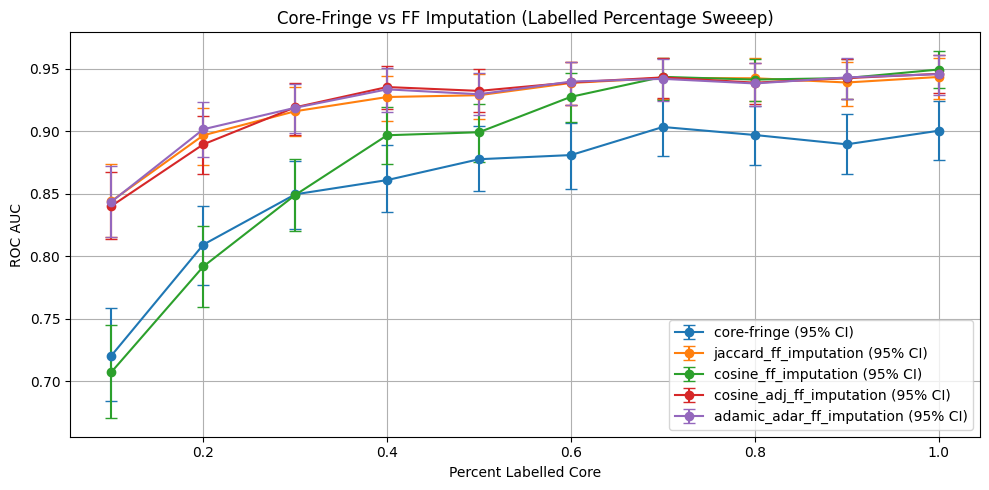

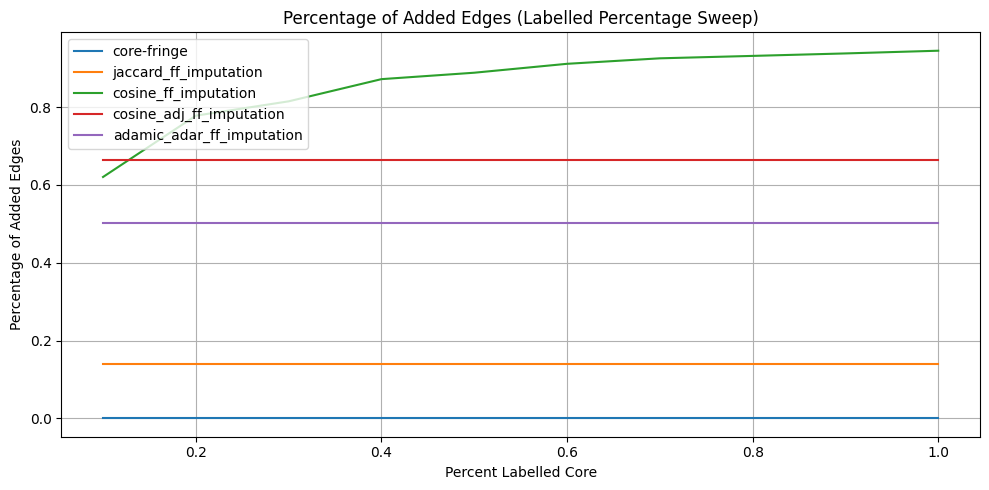

In [25]:
percentage_sweep()